In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
    
    

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


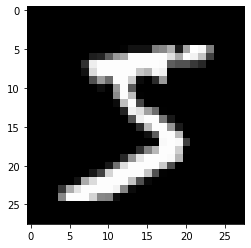

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)



In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
### neural network from scratch
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)





In [6]:
def log_softmax(x):
    return x -x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)


In [7]:
bs = 64
xb = x_train[0:64]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)


tensor([-2.9654, -2.0238, -2.0757, -1.8757, -2.0869, -2.2412, -2.4475, -2.8783,
        -2.4981, -2.4983], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean(-1)

loss_func = nll

yb= y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3484, grad_fn=<NegBackward>)


In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1094)


In [10]:
from IPython.core.debugger import set_trace

In [11]:
lr = 0.5
epochs = 2 

for epoch in range(epochs):
    for i in range((n-1) // bs +1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            

/home/gyasis/miniconda3/envs/autopytorch/lib/python3.9/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


In [12]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0807, grad_fn=<NegBackward>) tensor(1.)


In [13]:
# Now with torch.nn

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward>) tensor(1.)


In [14]:
    
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias    

In [15]:
model = Mnist_Logistic()

In [16]:
print(loss_func(model(xb), yb))

tensor(2.5188, grad_fn=<NllLossBackward>)


In [17]:
# previous loop 


# for epoch in range(epochs):
#     for i in range((n-1) // bs +1):
#         start_i = i * bs
#         end_i = start_i + bs
#         xb = x_train[start_i:end_i]
#         yb = y_train[start_i:end_i]
#         pred = model(xb)
#         loss = loss_func(pred, yb)
        
#         loss.backward()
#         with torch.no_grad():
#             weights -= weights.grad * lr
#             bias -= bias.grad * lr
#             weights.grad.zero_()
#             bias.grad.zero_()


def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs +1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()    
            
fit()

In [18]:
print(loss_func(model(xb), yb))

tensor(0.0830, grad_fn=<NllLossBackward>)


In [19]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
        
    def forward(self, xb):
        return self.lin(xb)

In [20]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3778, grad_fn=<NllLossBackward>)


In [21]:
fit()
print(loss_func(model(xb),yb))

tensor(0.0804, grad_fn=<NllLossBackward>)


In [22]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt  = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs 
        end_i = start_i + bs 
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))        

tensor(2.3447, grad_fn=<NllLossBackward>)
tensor(0.0817, grad_fn=<NllLossBackward>)


In [23]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [24]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb =train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        
print(loss_func(model(xb), yb))        
        
              

tensor(0.0822, grad_fn=<NllLossBackward>)


In [25]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=bs)

for xb, yb in train_dl:
    pred = model(xb)
    
model, opt = get_model()
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0804, grad_fn=<NllLossBackward>)


In [26]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)


In [27]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))       

0 tensor(0.3029)
1 tensor(0.2969)


In [28]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step(  )
        opt.zero_grad()
    return loss.item(), len(xb)    

In [29]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)        
        

In [30]:
def get_data(train_ds, valid_ds, bs):
    return ( 
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs *2),
            
            )        

In [31]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32619796608686447
1 0.29963203477859496


In [32]:
# CNN

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
                       
lr = 0.1                                  

In [33]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.38569582710266115
1 0.2759266707897186


In [34]:
## nn.sequential

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):    
        return self.func(x)
    
def preprocess(x):    
    return x.view(-1, 1, 28, 28)

In [35]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1,16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16,16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16,10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(),lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.02289142036438
1 0.8372313705444336


In [36]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
            
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)            
            
                
         

In [37]:
model = nn.Sequential(
    
    nn.Conv2d(1,16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16,16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16,10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
opt = optim.SGD(model.parameters(),lr=lr, momentum=0.9)

In [38]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3475101107358933
1 0.23465721834301947


In [39]:
print(torch.cuda.is_available())

False


In [40]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [41]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [42]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [43]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.2861466431736946
1 0.19988121993988753
